#  A Guide to Gradient Boosted Trees with XGBoost in Python

XGBoost has become incredibly popular on Kaggle in the last year for any problems dealing with structured data. I was already familiar with **sklearn’s version** of gradient boosting and have used it before, but I hadn’t really considered trying XGBoost instead until I became more familiar with it. I was perfectly happy with sklearn’s version and didn’t think much of switching. So why have so many started using it? There are a variety of answers I am sure others have come up with, but the main reason for me can be summarized in one word: **speed**

What about XGBoost makes it faster? Gradient boosted trees, as you may be aware, have to be built in series so that a step of gradient descent can be taken in order to minimize a loss function. Unlike Random Forests, you can’t simply build the trees in parallel. XGBoost, however, builds the tree itself in a parallel fashion. You can see more details about this in section 4.1 of the XGBoost paper by Chen and Guestrin here, but essentially the information contained in each feature column can have statistics calculated on it in parallel (along with an initial sort of the columns).

What you get in return for this speed is a much faster grid search for optimizing hyperparameters in model tuning.

To show you what the library can do in addition to some of its more advanced features, I am going to walk us through an example classification problem with the library.

### Getting and Preprocessing the Data

I decided a nice dataset to use for this example comes yet again from the UC-Irvine Machine Learning repository. This dataset is the classic **"Adult Data Set"**. An older set from 1996, this dataset contains census data on income. Our job is to predict whether a certain individual had an income of greater than 50,000 based on their demographic information. In the dataset description found here, we can see that the best model they came up with at the time had an accuracy of 85.95% (14.05% error on the test set). Let’s see if we can beat that, shall we?

First, load in numpy/pandas and download the data, which is split into train/test sets already for us. Make sure to skip a header row in this case or pandas will assume the first row is a header.

In [45]:
import numpy as np
import pandas as pd
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
# Make sure to skip a row for the test set
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', 
                       skiprows = 1, header = None) 

In [46]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [47]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


I notice a few problems immediately:

- We don’t have a column header for our data
- There seem to be some unknown values in the fifth row of the test set (the question marks) we need to deal with
- The target values have periods at the end in the test set but do not in the training set (<=50K. vs. <=50K)

Based on the accompanying dataset description, we can see the column names. Let’s put those in for our train and test first.

In [48]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

In [49]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [50]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
age               16281 non-null int64
workclass         16281 non-null object
fnlwgt            16281 non-null int64
education         16281 non-null object
education_num     16281 non-null int64
marital_status    16281 non-null object
occupation        16281 non-null object
relationship      16281 non-null object
race              16281 non-null object
sex               16281 non-null object
capital_gain      16281 non-null int64
capital_loss      16281 non-null int64
hours_per_week    16281 non-null int64
native_country    16281 non-null object
wage_class        16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


Try to remove rows with that contain an unknown marked with a ‘ ?’.

In [51]:
train_set.replace(' ?', np.nan).dropna().shape 

(30162, 15)

In [52]:
test_set.replace(' ?', np.nan).dropna().shape

(15060, 15)

In [53]:
train_nomissing = train_set.replace(' ?', np.nan).dropna()
test_nomissing = test_set.replace(' ?', np.nan).dropna()

We need these to match up appropriately, so we are going to need to fix either the test or training set to make them match up. Let’s replace all of the ‘<=50K.’ with ‘<=50K’ and the same for ‘>50K.’ with ‘>50K’, so essentially, we are just dropping the periods.

In [54]:
test_nomissing['wage_class'] = test_nomissing.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})

In [55]:
test_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

In [56]:
train_nomissing.wage_class.unique()

array([' <=50K', ' >50K'], dtype=object)

### Applying Ordinal Encoding to Categoricals

It seems that one-hot encoding isn’t necessary for tree-based algorithms, but you may run into a problem using this on linear models. I personally find ordinal encoding is more than sufficient and it significantly reduces your memory footprint if you have quite a few categorical features.

In [57]:
combined_set = pd.concat([train_nomissing, test_nomissing], axis = 0) # Stacks them vertically

In [58]:
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null object
fnlwgt            45222 non-null int64
education         45222 non-null object
education_num     45222 non-null int64
marital_status    45222 non-null object
occupation        45222 non-null object
relationship      45222 non-null object
race              45222 non-null object
sex               45222 non-null object
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null object
wage_class        45222 non-null object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [59]:
for feature in combined_set.columns: # Loop through all columns in the dataframe
    if combined_set[feature].dtype == 'object': # Only apply for columns with categorical strings
        combined_set[feature] = pd.Categorical(combined_set[feature]).codes # Replace strings with an integer

In [60]:
combined_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
age               45222 non-null int64
workclass         45222 non-null int8
fnlwgt            45222 non-null int64
education         45222 non-null int8
education_num     45222 non-null int64
marital_status    45222 non-null int8
occupation        45222 non-null int8
relationship      45222 non-null int8
race              45222 non-null int8
sex               45222 non-null int8
capital_gain      45222 non-null int64
capital_loss      45222 non-null int64
hours_per_week    45222 non-null int64
native_country    45222 non-null int8
wage_class        45222 non-null int8
dtypes: int64(6), int8(9)
memory usage: 2.8 MB


In [61]:
final_train = combined_set[:train_nomissing.shape[0]] # Up to the last initial training set row
final_test = combined_set[train_nomissing.shape[0]:] # Past the last initial training set row

### Initial Model Setup and Grid Search

In [62]:
y_train = final_train.pop('wage_class')
y_test = final_test.pop('wage_class')

In [63]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

This should help you better understand the choices I am making to start off our first grid search. I am going to start tuning on the `maximum_depth` of the trees first, along with the `min_child_weight`, which is very similar to `min_samples_split` in sklearn’s version of gradient boosted trees.

In [64]:
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 
# Optimize for accuracy since that is the metric used in the Adult Data Set notation

In [65]:
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [67]:
optimized_GBM.grid_scores_

[mean: 0.86685, std: 0.00239, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.86659, std: 0.00371, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.86725, std: 0.00317, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.86178, std: 0.00317, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.85953, std: 0.00251, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.86158, std: 0.00239, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.85611, std: 0.00330, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.85525, std: 0.00323, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.85714, std: 0.00320, params: {'max_depth': 7, 'min_child_weight': 5}]

We can see that the 3rd hyperparameter combination performed best and we already beat our target of 85.95% accuracy in our cross-validation! Let’s try optimizing some other hyperparameters now to see if we can beat a mean of 86.73% accuracy. This time, we will play around with `subsampling` along with lowering the `learning_rate` to see if that helps.

In [68]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 1000, 'seed':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1)
optimized_GBM.fit(final_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [70]:
optimized_GBM.grid_scores_

[mean: 0.86622, std: 0.00271, params: {'learning_rate': 0.1, 'subsample': 0.7},
 mean: 0.86685, std: 0.00239, params: {'learning_rate': 0.1, 'subsample': 0.8},
 mean: 0.86771, std: 0.00349, params: {'learning_rate': 0.1, 'subsample': 0.9},
 mean: 0.85999, std: 0.00307, params: {'learning_rate': 0.01, 'subsample': 0.7},
 mean: 0.86032, std: 0.00272, params: {'learning_rate': 0.01, 'subsample': 0.8},
 mean: 0.86002, std: 0.00282, params: {'learning_rate': 0.01, 'subsample': 0.9}]

No, it doesn’t look like we can improve on this. However, we may be able to optimize a little further by utilizing XGBoost’s built-in cv which allows early stopping to prevent overfitting.

### Early stopping CV

Based on the CV testing performed earlier, we want to utilize the following parameters:

- `Learning_rate` (eta) = 0.1
- `Subsample`, `colsample_bytree` = 0.8
- `Max_depth` = 3
- `Min_child_weight` = 1

There are a few other parameters we could tune in theory to squeeze out further performance, but this is a good enough starting point.

To increase the performance of XGBoost’s speed through many iterations of the training set, and since we are using only XGBoost’s API and not sklearn’s anymore, we can create a DMatrix. This sorts the data initially to optimize for XGBoost when it builds trees, making the algorithm more efficient. This is especially helpful when you have a very large number of training examples. To create a DMatrix:

In [71]:
xgdmat = xgb.DMatrix(final_train, y_train) # Create our DMatrix to make XGBoost more efficient

For now, let’s be aggressive with the stopping and say we don’t want the accuracy to improve for at least 100 new trees.

In [84]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [85]:
cv_xgb.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
457,0.130173,0.004067,0.116570,0.001104
458,0.130106,0.004026,0.116578,0.001137
459,0.130040,0.003949,0.116520,0.001080
460,0.130073,0.003919,0.116537,0.001141
461,0.129974,0.003961,0.116512,0.001133


Our CV test error at this number of iterations is 12.997%, or 87.003% accuracy. Now that we have our best settings, let’s create this as an XGBoost object model that we can reference later.

In [87]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = cv_xgb.shape[0])

Notice that it trains very quickly. With our XG model object, we can then plot our feature importances using a built-in method. This is similar to the feature importances found in sklearn.

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1.5)

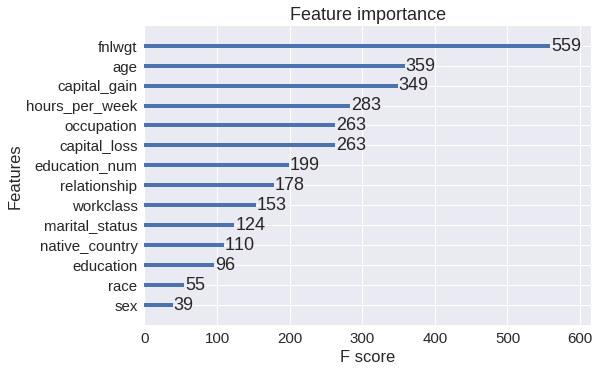

In [89]:
xgb.plot_importance(final_gb)
plt.show()

This will tell us which features were most important in the series of trees. The `fnlwgt` feature seems to have the most importance. Filing `capital gains` was also important, which makes sense given that only those with greater incomes have the ability to invest. `Race` and `sex` were not as important. This may be because we are just predicting a specific threshold (below/above 50000 a year) instead of a precise income.

### Importance

If the built-in feature importance method isn’t what you wanted, you can make your own chart of feature importances using the `get_fscore` method:

In [77]:
importances = final_gb.get_fscore()
importances

{'age': 338,
 'capital_gain': 339,
 'capital_loss': 253,
 'education': 83,
 'education_num': 190,
 'fnlwgt': 507,
 'hours_per_week': 260,
 'marital_status': 115,
 'native_country': 106,
 'occupation': 244,
 'race': 50,
 'relationship': 166,
 'sex': 38,
 'workclass': 140}

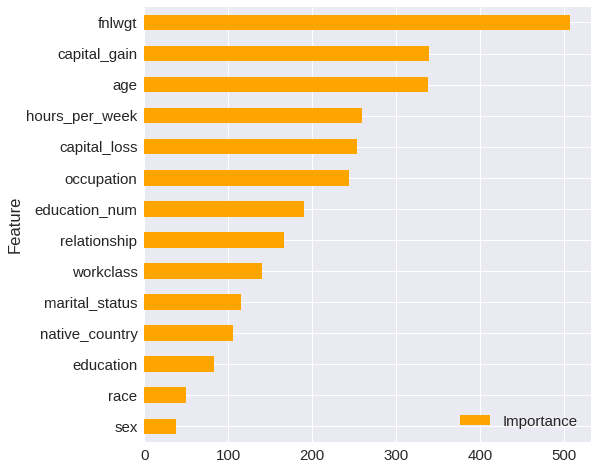

In [78]:
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')
plt.show()

Now that we have an understanding of the feature importances, we can at least figure out better what is driving the splits most for the trees and where we may be able to make some improvements in feature engineering if possible. You can try playing around with the hyperparameters yourself or engineer some new features to see if you can beat the current benchmarks.

### Analyzing Performance on Test Data

In [79]:
testdmat = xgb.DMatrix(final_test)

In [80]:
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred

array([ 0.00303194,  0.20714261,  0.3024281 , ...,  0.82887119,
        0.16432679,  0.78854781], dtype=float32)

You can see that the predict function for XGBoost outputs probabilities by default and not actual class labels. To calculate accuracy we need to convert these to a 0/1 label. We will set 0.5 probability as our threshold.

In [81]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([ 0.,  0.,  0., ...,  1.,  0.,  1.], dtype=float32)

In [82]:
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.86865869853917665, 0.13134130146082335)

### Ideas for Improvement and Summary

In this post, we explored some of the basic functionality involving the XGBoost library. We also learned how it works and why it performs faster than other gradient boosting libraries do. As a test, we used it on an example dataset of US incomes, beating the performance of other documented models for the dataset with very little effort. We were also able to investigate feature importances to see which features were influencing the model most.

Possible ideas for using XGBoost in the future:

- Make sure to read the documentation thoroughly if you want to utilize some of its more advanced features
- This is a rapidly evolving library, so additional features may be introduced that affect its functionality
- XGBoost is available in most of the other common languages for data science as well such as Julia and R if those are preferable
- XGBoost can also now be utilized at scale, running on Spark and Flink with the recently released XGBoost4J